In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import warnings
# warnings.filterwarnings('ignore')

In [ ]:
x=np.linspace(0,100,501)
y=np.sin(x)

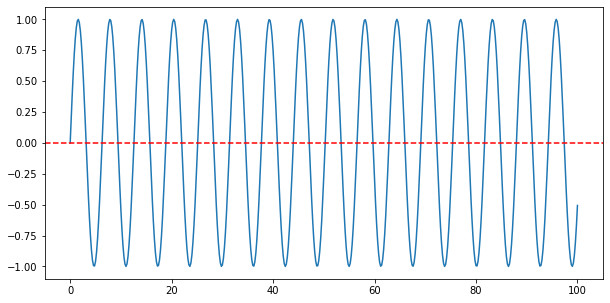

In [ ]:
#Visualize the x and y
from numpy.ma.core import dot
plt.figure(figsize=(10,5))
plt.plot(x,y)
plt.axhline(y=0.00,color='r',linestyle="--")

In [ ]:
data=pd.DataFrame(data=y,index=x,columns=["Sine"])

In [ ]:
test_data_size=0.1
test_size=len(data)*test_data_size
print(test_size)

50.1


In [ ]:
test=data.iloc[-int(np.round(test_size)):]
train=data.iloc[:(len(data)-int(np.round(test_size)))]

In [ ]:
#Normalising the data
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(train)
scale_train=scaler.transform(train)
scaler_test=scaler.transform(test)

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
batch_size=1
length=50
__generator__=TimeseriesGenerator(scale_train,scale_train,length=length,batch_size=batch_size)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM

In [ ]:
model=Sequential([
    SimpleRNN(50,input_shape=(length,1)),             # Input shape - BATCH_SIZE,SEQUENCES_LENGTH,N_DIM
    Dense(1)
])
model.compile(optimizer="adam",loss="mse")
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [ ]:
model.fit_generator(__generator__,epochs=5)

Epoch 1/5
  1/401 [..............................] - ETA: 44s - loss: 0.4388

<ipython-input-44-53ed8e6a409e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(__generator__,epochs=5)
/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


401/401 [==============================] - 33s 82ms/step - loss: 0.0039
Epoch 2/5
401/401 [==============================] - 33s 82ms/step - loss: 8.1280e-04
Epoch 3/5
401/401 [==============================] - 33s 82ms/step - loss: 0.0011
Epoch 4/5
401/401 [==============================] - 32s 79ms/step - loss: 3.4767e-06
Epoch 5/5
401/401 [==============================] - 33s 81ms/step - loss: 1.3239e-04


<Figure size 720x360 with 0 Axes>

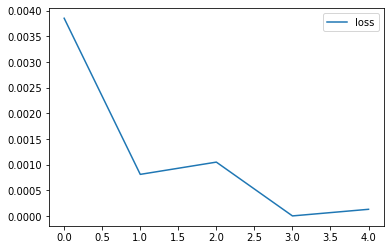

In [ ]:
plt.figure(figsize=(10,5))
losses=model.history.history
pd.DataFrame(losses).plot()

In [ ]:
#Here we are making predictions
#Using scaled train of last 50 values
last_50_train=scale_train[-length:]
last_predicted=scaler_test[0]
predicted_last_50_value=model.predict(last_50_train.reshape(batch_size,length,1)) #Batch_size,sequence_length,n_inputs

print("Expected value :",last_predicted[0],"\nTrue value :",predicted_last_50_value[0][0])

1/1 [==============================] - 0s 63ms/step
Expected value : 0.8935799295851706 
True value : 0.86593664


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [ ]:
#Now we predict Next 50/Future data points
predictions=[]
Batch=last_50_train.reshape(batch_size,length,1)
for i in range(len(scaler_test)):
  curr_pred=model.predict(Batch)[0][0]
  predictions.append(curr_pred)
  Batch=np.append(Batch[:,1:,:],[[[curr_pred]]],axis=1)

1/1 [==============================] - 0s 81ms/step


In [ ]:
predictions

[0.86593664,
 0.80143565,
 0.713664,
 0.60818756,
 0.5111433,
 0.40662456,
 0.31279758,
 0.21956085,
 0.1487705,
 0.093700126,
 0.05205111,
 0.04264676,
 0.046498362,
 0.08130199,
 0.12726304,
 0.19209157,
 0.2785214,
 0.3633992,
 0.46382177,
 0.5568677,
 0.65403533,
 0.7386142,
 0.806245,
 0.86935747,
 0.9070572,
 0.92967993,
 0.93015426,
 0.9141561,
 0.8806562,
 0.8224916,
 0.7575286,
 0.6722636,
 0.5827303,
 0.4843959,
 0.38527668,
 0.29592562,
 0.20624165,
 0.13745669,
 0.08379291,
 0.051592678,
 0.04354684,
 0.051423647,
 0.093371436,
 0.143315,
 0.21660396,
 0.30203208,
 0.3926875,
 0.4948101,
 0.58423513,
 0.6808137]

In [ ]:
transformed_predictions=scaler.inverse_transform(np.array(predictions).reshape(-1,1))

In [ ]:
__transformed_predictions__=pd.DataFrame(scaler_test,columns=["Test Sine"])
__transformed_predictions__["Test Predicted"]=predictions

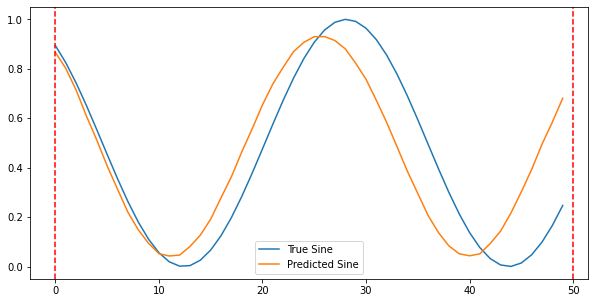

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(__transformed_predictions__["Test Sine"])
plt.plot(__transformed_predictions__["Test Predicted"])
plt.legend(["True Sine","Predicted Sine"])
plt.axvline(x=0,color='r',linestyle="--")
plt.axvline(x=50,color='r',linestyle="--")

#####        ---------------     USING LSTM       ---------------

In [ ]:
batch_size=1
length=49
__LSTM_generator__=TimeseriesGenerator(scale_train,scale_train,length=length,batch_size=batch_size)
__validation_generator__=TimeseriesGenerator(scaler_test,scaler_test,length=length,batch_size=batch_size)

model=Sequential([
    LSTM(50,input_shape=(length,1)),             # Input shape - BATCH_SIZE,SEQUENCES_LENGTH,N_DIM
    Dense(1)
])
model.compile(optimizer="adam",loss="mse")
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early=EarlyStopping(monitor="val_loss",patience=0)
model.fit_generator(__LSTM_generator__,epochs=20,validation_data=__validation_generator__,callbacks=[early])

Epoch 1/20
  4/402 [..............................] - ETA: 7s - loss: 0.3933 

<ipython-input-53-66a7d524de01>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(__LSTM_generator__,epochs=20,validation_data=__validation_generator__,callbacks=[early])
/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


402/402 [==============================] - 8s 20ms/step - loss: 0.0276 - val_loss: 2.3597e-06
Epoch 2/20
402/402 [==============================] - 8s 20ms/step - loss: 1.4053e-05 - val_loss: 5.6748e-07


<Figure size 720x360 with 0 Axes>

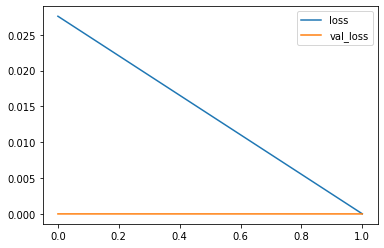

In [ ]:
plt.figure(figsize=(10,5))
losses=model.history.history
pd.DataFrame(losses).plot()

In [ ]:
predictions_of_LSTM=[]
last_50_train=scale_train[-length:]
Batch=last_50_train.reshape(batch_size,length,1)
for i in range(len(scaler_test)):
  curr_pred=model.predict(Batch)[0][0]
  predictions_of_LSTM.append(curr_pred)
  Batch=np.append(Batch[:,1:,:],[[[curr_pred]]],axis=1)


transformed_predictions=scaler.inverse_transform(np.array(predictions_of_LSTM).reshape(-1,1))

1/1 [==============================] - 0s 21ms/step


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 24ms/step


In [ ]:
__transformed_predictions__=pd.DataFrame(scaler_test,columns=["Test Sine"])
__transformed_predictions__["RNN Predicted"]=predictions
__transformed_predictions__["LSTM Predicted"]=predictions_of_LSTM

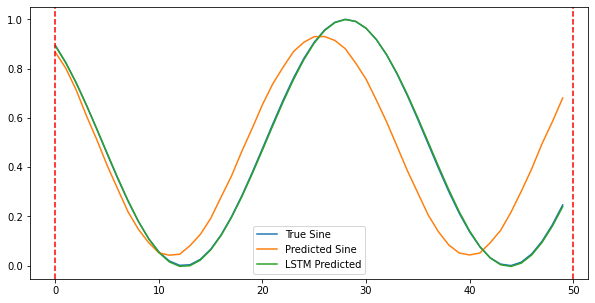

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(__transformed_predictions__["Test Sine"])
plt.plot(__transformed_predictions__["RNN Predicted"])
plt.plot(__transformed_predictions__["LSTM Predicted"])
plt.legend(["True Sine","Predicted Sine","LSTM Predicted"])
plt.axvline(x=0,color='r',linestyle="--")
plt.axvline(x=50,color='r',linestyle="--")

In [ ]:
full_data=pd.DataFrame(y,x)

**-- PREDICT FEATURE FORECAST ---**

In [ ]:
Full_scale=MinMaxScaler()
scaled_full_data=Full_scale.fit_transform(full_data)



batch_size=1
length=30
__LSTM_generator__=TimeseriesGenerator(scaled_full_data,scaled_full_data,length=length,batch_size=batch_size)

model=Sequential([
    LSTM(50,input_shape=(length,1)),             # Input shape - BATCH_SIZE,SEQUENCES_LENGTH,N_DIM
    Dense(1)
])
model.compile(optimizer="adam",loss="mse")
print(model.summary())

early=EarlyStopping(monitor="val_loss",patience=0)
model.fit_generator(__LSTM_generator__,epochs=20,callbacks=[early])



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                10400     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
  7/471 [..............................] - ETA: 8s - loss: 0.3693

<ipython-input-59-ed7e27deede3>:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(__LSTM_generator__,epochs=20,callbacks=[early])
/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


470/471 [============================>.] - ETA: 0s - loss: 0.0171

471/471 [==============================] - 9s 19ms/step - loss: 0.0170
Epoch 2/20
469/471 [============================>.] - ETA: 0s - loss: 1.0331e-05

471/471 [==============================] - 9s 18ms/step - loss: 1.0310e-05
Epoch 3/20
469/471 [============================>.] - ETA: 0s - loss: 2.2050e-04

471/471 [==============================] - 9s 19ms/step - loss: 2.1997e-04
Epoch 4/20
470/471 [============================>.] - ETA: 0s - loss: 2.0775e-05

471/471 [==============================] - 10s 20ms/step - loss: 2.0744e-05
Epoch 5/20
471/471 [==============================] - ETA: 0s - loss: 7.9573e-04

471/471 [==============================] - 9s 19ms/step - loss: 7.9573e-04
Epoch 6/20
471/471 [==============================] - ETA: 0s - loss: 2.1027e-05

471/471 [==============================] - 8s 17ms/step - loss: 2.1027e-05
Epoch 7/20
471/471 [==============================] - ETA: 0s - loss: 3.1372e-05

471/471 [==============================] - 9s 19ms/step - loss: 3.1372e-05
Epoch 8/20
469/471 [============================>.] - ETA: 0s - loss: 3.7484e-05

471/471 [==============================] - 9s 19ms/step - loss: 3.7344e-05
Epoch 9/20
469/471 [============================>.] - ETA: 0s - loss: 1.2671e-04

471/471 [==============================] - 8s 18ms/step - loss: 1.2624e-04
Epoch 10/20
470/471 [============================>.] - ETA: 0s - loss: 6.5475e-04

471/471 [==============================] - 8s 18ms/step - loss: 6.5350e-04
Epoch 11/20
469/471 [============================>.] - ETA: 0s - loss: 2.4641e-05

471/471 [==============================] - 9s 18ms/step - loss: 2.4550e-05
Epoch 12/20
471/471 [==============================] - ETA: 0s - loss: 2.3844e-05

471/471 [==============================] - 9s 19ms/step - loss: 2.3844e-05
Epoch 13/20
471/471 [==============================] - ETA: 0s - loss: 6.5138e-05

471/471 [==============================] - 9s 19ms/step - loss: 6.5138e-05
Epoch 14/20
470/471 [============================>.] - ETA: 0s - loss: 1.7089e-04

471/471 [==============================] - 9s 19ms/step - loss: 1.7093e-04
Epoch 15/20
469/471 [============================>.] - ETA: 0s - loss: 1.0036e-04

471/471 [==============================] - 9s 19ms/step - loss: 1.0038e-04
Epoch 16/20
471/471 [==============================] - ETA: 0s - loss: 2.1283e-05

471/471 [==============================] - 9s 19ms/step - loss: 2.1283e-05
Epoch 17/20
469/471 [============================>.] - ETA: 0s - loss: 8.5561e-05

471/471 [==============================] - 9s 19ms/step - loss: 8.7473e-05
Epoch 18/20
471/471 [==============================] - ETA: 0s - loss: 7.0307e-05

471/471 [==============================] - 8s 18ms/step - loss: 7.0307e-05
Epoch 19/20
470/471 [============================>.] - ETA: 0s - loss: 5.1853e-05

471/471 [==============================] - 9s 19ms/step - loss: 5.2047e-05
Epoch 20/20
469/471 [============================>.] - ETA: 0s - loss: 5.1348e-05

471/471 [==============================] - 9s 19ms/step - loss: 5.1240e-05


In [ ]:
forcast_of_LSTM=[]
last_50_train=scale_train[-length:]
Batch=last_50_train.reshape(batch_size,length,1)
for i in range(80):
  curr_pred=model.predict(Batch)[0][0]
  forcast_of_LSTM.append(curr_pred)
  Batch=np.append(Batch[:,1:,:],[[[curr_pred]]],axis=1)


transformed_forcast=scaler.inverse_transform(np.array(forcast_of_LSTM).reshape(-1,1))

1/1 [==============================] - 0s 23ms/step


In [ ]:
80*0.1

8.0

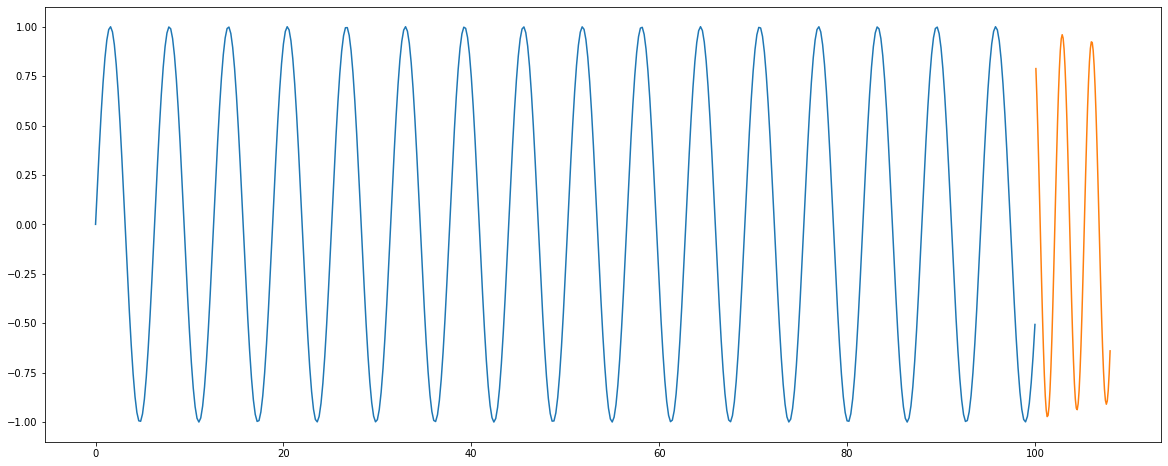

In [ ]:
forcast_index=np.arange(100.1,108.1,step=0.1)
plt.figure(figsize=(20,8))
plt.plot(x,y)
plt.plot(forcast_index,transformed_forcast)